In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from fastseg import MobileV3Small, MobileV3Large
from fastseg.image.colorize import colorize, blend
from dataloader import UROBDataset
import torchvision.transforms.v2 as transforms
import torchvision
import cv2
from PIL import Image
from tqdm import tqdm
from utils import *
from lovacs_losses import lovasz_softmax
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = 'cuda:0'
if not torch.cuda.is_available():
    device = 'cpu'

print(device)

cuda:0


Training hyperparameters

In [9]:
# dataset config
label_mapping = {
    200 : 2,
    201 : 1
}
ignore_label = 10
unique_labels = [0, 1, 2]
label_names = ['other', 'rb_car', 'other_car']
filepaths_trn = './experiments/radim/train_filenames.pkl'
filepaths_val = './experiments/radim/val_filenames.pkl'

# model save paths
model_save_path = './experiments/radim/model.pt'
model_checkpoint_save_path = './experiments/radim/checkpoint.pt'

# training hyperparams
learning_rate = 1e-3
weight_decay = learning_rate * 1e-1
num_epoch = 20
batch_size = 2

do_random_perspective = True

Create Dataset and Dataloader objects

In [10]:
# tensorboard logging
writer = SummaryWriter() # uncomment for tensorboard

# construct the dataloader
transform = transforms.Compose([
    transforms.RandomAutocontrast()
])


# construct the dataset
target_shape = [512, 1024]
train_dataset = UROBDataset(filenames_file=filepaths_trn, target_img_shape=target_shape, label_mapping=label_mapping, ignore_label=ignore_label, p_cutmix=0.7)
val_dataset = UROBDataset(filenames_file=filepaths_val, target_img_shape=target_shape, label_mapping=label_mapping, ignore_label=ignore_label, p_cutmix=0.7)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                          shuffle=True, num_workers=1)

Show some example data

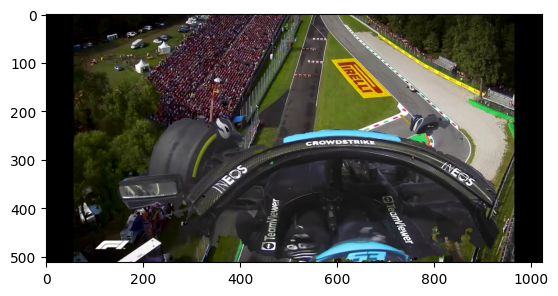

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


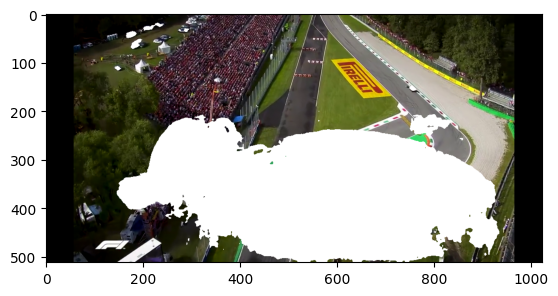

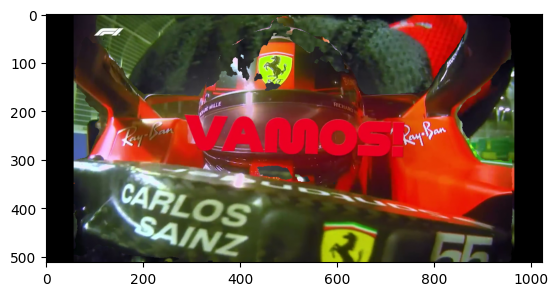

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


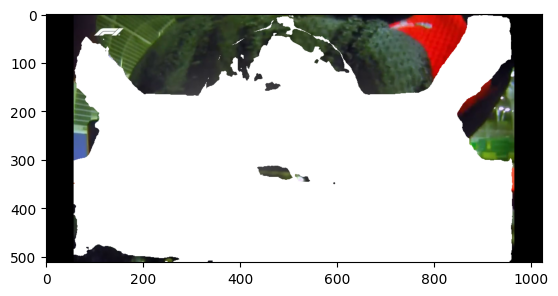

In [11]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
for i in range(images.shape[0]):
    image = images[i, :, :, :]
    label = labels[i, :, :]
    seg_image = image.clone()
    seg_image[:, label==1] = 0
    seg_image[:, label==2] = 255
    imshow(image)
    imshow(seg_image)


Define Model, Optimizer and Learnining Rate scheduler + Loss function handle

In [12]:
model = MobileV3Large(num_classes=3)
#model = MobileV3Small(num_classes=3)

model = model.to(device=device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.8)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=2, min_lr=1e-6)

# define loss function
def criterion(outputs, labels):
    probas = F.softmax(outputs, dim=1)
    loss = lovasz_softmax(probas, labels, ignore=ignore_label) + F.cross_entropy(outputs, labels, ignore_index=ignore_label, reduction='none').mean()
    
    return loss

Main Training Loop

In [13]:

best_val_miou = -torch.inf
total_iter = 0

for epoch in range(num_epoch):
    pbar = tqdm(total=len(train_loader))
    model.train()
    for iter, data in enumerate(train_loader):
        X_trn, y_trn = data
        # TODO() augmentation to the dataloader

        # augment the data
        if torch.rand(1).item() > 0.5:
            X_trn = transform(X_trn)        

            if do_random_perspective:
                X_trn = transforms.RandomPerspective(interpolation=transforms.InterpolationMode.BILINEAR).__call__(X_trn)
                y_trn = transforms.RandomPerspective(interpolation=transforms.InterpolationMode.NEAREST).__call__(y_trn.unsqueeze(1)).squeeze(1)

        # run through model
        X_trn = X_trn.float().to(device=device)
        y_trn = y_trn.long().to(device=device)
        output = model(X_trn)
        # compute loss
        loss = criterion(output, y_trn)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        predict_labels = torch.argmax(output, dim=1)
        cur_acc = fast_accuracy_approx(predict_labels , y_trn, train_dataset.ignore_label)
        pbar.set_description(f'epoch: {epoch} | loss: {loss.item():.4f} | acc: {(100 * cur_acc.item()):.3f}%')
        writer.add_scalar('Loss/Train', loss.item(), total_iter) # uncomment for tensorboard
        writer.add_scalar('Acc/Train', cur_acc.item(), total_iter) # uncomment for tensorboard

        total_iter += 1
        pbar.update(1)
    pbar.close()

    # validate model
    loss_hist, cls_tp_hist, cls_tn_hist, cls_fp_hist, cls_fn_hist = validate(
        val_dataloader=val_loader,
        model=model,
        criterion=criterion,
        unique_labels = unique_labels,
        device=device,
        visualize=False,
        ignore_label=ignore_label
    )

    # print stats
    loss_mean = loss_hist.mean().item()
    cls_iou = compute_cls_iou(cls_tp=cls_tp_hist, cls_tn=cls_tn_hist, cls_fp=cls_fp_hist, cls_fn=cls_fn_hist)
    miou = cls_iou.mean().item()
    print(f'epoch: {epoch} results: ')
    print(f'loss: {loss_mean}')
    for i  in range(len(label_names)):
        print(f'class {label_names[i]} IoU: {100 * cls_iou[i].item()}%')
        writer.add_scalar(f'{label_names[i]}/IoU', cls_iou[i].item(), total_iter) # uncomment for tensorboard
    
    print(f'mIoU: {miou * 100}% / best mIoU: {best_val_miou * 100}%')
    writer.add_scalar('Loss/Validation', loss_mean, total_iter) # uncomment for tensorboard
    writer.add_scalar('mIoU/IoU', miou, total_iter) # uncomment for tensorboard

    # update lr_scheduler
    lr_scheduler.step() # for stepLR
    #lr_scheduler.step(loss_mean) # ReduceOnPlateau
    

    # save progress
    if best_val_miou < miou:
        best_val_miou = miou
        with open(model_save_path, 'wb') as file:
            torch.save(model.state_dict(), file)
    with open(model_checkpoint_save_path, 'wb') as file:
            torch.save(model.state_dict(), file)
        

epoch: 0 | loss: 1.2787 | acc: 65.962%:   8%|▊         | 21/263 [00:15<02:03,  1.96it/s]